### notes

- temporal embedder mixing
- periodic swin windows
- hidden dim node incr encode embeddings
- incr batch size?
- incr init lr
- swish act
- save model for each epoch
- clim balanced anim
- reduction mean or none? mse loss
- init timesteps seq on gpu isntead of moving for each it for loop
- calibrate vmax on true and not all
- trajectory split savings check for multigpu? no rank zero only

# Flowmatching approach

In [1]:
import os
import subprocess
def check_mig_with_smi():
    try:
        output = subprocess.check_output(["nvidia-smi", "-L"], text=True)
        return "MIG" in output
    except (subprocess.CalledProcessError, FileNotFoundError):
        return False

if check_mig_with_smi():
    print("Running on a GPU MIG instance")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    print("Not running on a GPU MIG instance")

import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#1F1F1F'
plt.rcParams['axes.facecolor'] = '#1F1F1F'
plt.rcParams['savefig.facecolor'] = '#1F1F1F'

from torchvision.transforms import GaussianBlur
from scipy.ndimage import gaussian_filter
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import time

Running on a GPU MIG instance


## model code

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from einops.layers.torch import Rearrange
import numpy as np
import math
from modelComp.utils import ConvNeXtBlock, ResNetBlock, SwiGLU, MLP


def window_partition(x, window_size):

    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):

    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

def gen_t_embedding(t, emb_dim, max_positions=10000):
    t = t * max_positions
    half_dim = emb_dim // 2
    emb = math.log(max_positions) / (half_dim - 1)
    #emb = torch.arange(half_dim).float().mul(-emb).exp()
    emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
    emb = t[:, None] * emb[None, :]
    emb = torch.cat([emb.sin(), emb.cos()], dim=1)
    return emb


class LinearEmbedding(nn.Module):

    def __init__(self, emb_dim = 96, data_dim = (1,5,4,128,128), patch_size = (8,8), hiddenout_dim = 256, act=nn.GELU):
        super().__init__()
        
        self.B, self.T, self.C, self.H, self.W = data_dim
        self.emb_dim = emb_dim
        self.pH, self.pW = patch_size
        self.hiddenout_dim = hiddenout_dim
        self.patch_grid_res = (self.H // self.pH, self.W // self.pW)
        

        assert self.H % self.pH == 0 and self.W % self.pW == 0, "spatial input dim must be divisible by patch_size"
        assert self.H == self.W, "must be square"
        

        self.patchify = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        self.unpatchify = nn.Fold(output_size=(self.H, self.W), kernel_size=patch_size, stride=patch_size)
        self.pre_proj = nn.Sequential(
            nn.Linear(self.C * self.pH * self.pW, self.emb_dim * 2 if act == SwiGLU else self.emb_dim), ##################flowmatching encoding
            act(),
            nn.Linear(self.emb_dim, self.emb_dim),
        )

        self.post_proj = nn.Sequential(
            nn.Linear(self.emb_dim, self.hiddenout_dim* 2 if act == SwiGLU else self.hiddenout_dim),
            act(),
            nn.Linear(self.hiddenout_dim, self.hiddenout_dim* 2 if act == SwiGLU else self.hiddenout_dim),
            act(),
            nn.Linear(self.hiddenout_dim, self.C * self.pH * self.pW),
        )

    #def get_pos_embeddings(self, t_len):
    #    return (self.time_embed[:, :t_len] + self.patch_position_embeddings).view(1, -1, self.emb_dim)  # (1, t*p*p, d)

    def encode(self, x, t, proj=True):

        B, T, C, H, W = x.shape

        x = rearrange(x, 'b t c h w -> (b t) c h w')

        x = self.patchify(x)  

        x = rearrange(x, '(b t) d n -> b t n d', b=B, t=T)

        if proj:
            x = self.pre_proj(x)
            #t = t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, x.shape[1], x.shape[2], 1)  # (B, T, N, 1)
            #print('t shape', t.shape)
            #print('x shape', x.shape)
            #x = torch.cat((x, t), dim=-1)
            return x
        else:
            return x

    def decode(self, x, proj=True):
        if proj:
            x = self.post_proj(x)  

        B, T, N, D = x.shape
        x = rearrange(x, 'b t n d -> (b t) d n')
        
        x = self.unpatchify(x)  
        x = rearrange(x, "(b t) c h w -> b t c h w", b=B, t=T)

        return x

class SpatiotemporalPositionalEncoding(nn.Module):
    def __init__(self, emb_dim, height, width, timesteps):
        super().__init__()
        self.emb_dim = emb_dim
        self.H = height
        self.W = width
        self.T = timesteps

        assert emb_dim % 2 == 0, "emb_dim must be divisible by 2"
        self.row_embed = nn.Parameter(torch.randn(1, self.H, 1, emb_dim // 2))
        self.col_embed = nn.Parameter(torch.randn(1, 1, self.W, emb_dim // 2))
        self.time_embed = nn.Parameter(torch.randn(1, self.T, 1, emb_dim))  # full D for time

    def forward(self, x):
        # x: (B, T, N, D)
        B, T, N, D = x.shape
        H, W = self.H, self.W
        assert N == H * W, f"Expected N = H*W = {H}x{W}, got {N}"

        # Spatial embeddings: (1, H, W, D)
        spatial = torch.cat([
            self.row_embed.expand(-1, H, W, -1),  # (1, H, W, D//2)
            self.col_embed.expand(-1, H, W, -1)   # (1, H, W, D//2)
        ], dim=-1).view(1, 1, N, D)  # -> (1, 1, N, D)

        # Temporal embedding: (1, T, 1, D)
        time = self.time_embed  # already (1, T, 1, D)

        pos = spatial + time  # broadcasts over (B, T, N, D)

        return x + pos
 
class PatchMerge(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.linear = nn.Linear(4*emb_dim, 2*emb_dim)

    def forward(self, x):
        B, T, L, C = x.shape
        H = W = int(np.sqrt(L)/2)
        x = rearrange(x, 'b t (h s1 w s2) c -> b t (h w) (s1 s2 c)', s1=2, s2=2, h=H, w=W) #might change to .permute
        x = self.linear(x)
        return x

class PatchUnMerge(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.linear = nn.Linear(emb_dim, 2*emb_dim)
    
    def forward(self, x):
        B, T, L, C = x.shape
        H = W = int(np.sqrt(L))
        #print(x.shape, H, W)
        x = self.linear(x)
        #print(x.shape)
        x = rearrange(x, 'b t (h w) (s1 s2 c) -> b t (h s1 w s2) c', s1=2, s2=2, h=H, w=W) #might change to .permute
        return x


class WindowAttention(nn.Module):

    def __init__(self, emb_dim, window_size, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.,
    use_flex_attn=True, act=nn.ReLU):

        super().__init__()
        self.emb_dim = emb_dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.qkv_bias = qkv_bias
        self.use_flex_attn = use_flex_attn # original from logits scale BCAT?

        assert emb_dim % num_heads == 0, "embedding dimension must be divisible by number of heads"
        

        if self.use_flex_attn: 
            self.flex_attn = nn.Parameter(torch.log(10 * torch.ones((num_heads, 1, 1))), requires_grad=True)
            flex_limit = torch.log(torch.tensor(1. / 0.01))
            self.register_buffer("flex_limit", flex_limit)
            #self.register_parameter("flex_attn", nn.Parameter(self.flex_attn))

        # mlp to generate continuous relative position bias
        self.cpb_mlp = nn.Sequential(nn.Linear(2, 512, bias=True),
                                     act(),
                                     nn.Linear(512, num_heads, bias=False))

        # get relative_coords_table
        relative_coords_h = torch.arange(-(self.window_size[0] - 1), self.window_size[0], dtype=torch.float32)
        relative_coords_w = torch.arange(-(self.window_size[1] - 1), self.window_size[1], dtype=torch.float32)
        relative_coords_table = torch.stack(
            torch.meshgrid([relative_coords_h,
                            relative_coords_w])).permute(1, 2, 0).contiguous().unsqueeze(0)  
        
        relative_coords_table[:, :, :, 0] /= (self.window_size[0] - 1)
        relative_coords_table[:, :, :, 1] /= (self.window_size[1] - 1)
        relative_coords_table *= 8  # normalize to -8, 8 TODO: understand why
        relative_coords_table = torch.sign(relative_coords_table) * torch.log2(
            torch.abs(relative_coords_table) + 1.0) / np.log2(8)

        self.register_buffer("relative_coords_table", relative_coords_table)

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w])) 
        coords_flatten = torch.flatten(coords, 1)  
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  
        relative_coords[:, :, 0] += self.window_size[0] - 1  
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(emb_dim, emb_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(emb_dim))
            self.v_bias = nn.Parameter(torch.zeros(emb_dim))
            #print(self.q_bias.device, self.v_bias.device)
            # TODO: understand why not key bias
        else:
            self.q_bias = None
            self.v_bias = None
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_out = nn.Linear(emb_dim, emb_dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):

        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        #print('test')
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # cosine attention
        attn = (F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2, -1))
        '''
        if self.use_flex_attn:
            flex_attn = torch.clamp(self.flex_attn, max=torch.log(torch.tensor(1. / 0.01, device=x.device))).exp()
            attn = attn * flex_attn
        '''
        if self.use_flex_attn:
            #print('windowattn')
            #print(attn.shape, self.flex_attn.shape, x.device, torch.tensor(1. / 0.01))
            #clamp_max = torch.tensor(100.)
            #print(clamp_max)
            #clamp_max = torch.log(clamp_max)
            #print(clamp_max, clamp_max.shape, self.flex_attn.shape)
            #flex_attn = torch.clamp(self.flex_attn, max=clamp_max).exp()
            #print(flex_attn.shape, self.flex_attn.shape)
            #flex_attn = flex_attn.expand(attn.shape)  # Match shape exactly to attn
            flex_attn = torch.clamp(self.flex_attn, max=self.flex_limit).exp()
                        
            #print(flex_attn.shape, self.flex_attn.shape)
            attn = attn * flex_attn
        #print('attn', attn.shape)

        relative_position_bias_table = self.cpb_mlp(self.relative_coords_table).view(-1, self.num_heads)
        relative_position_bias = relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1) 
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  
        relative_position_bias = 16 * torch.sigmoid(relative_position_bias)
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj_out(x)
        x = self.proj_drop(x)
        return x

    
class SpatialSwinBlock(nn.Module): #change name to something else

    def __init__(self, emb_dim, patch_grid_res, num_heads, window_size=4, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., use_flex_attn=True, 
                 act=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.emb_dim = emb_dim
        self.patch_grid_res = patch_grid_res
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        #self.use_proj_in = use_proj_in
        #print('shift_size', self.shift_size)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(emb_dim)
        #print('test')
        self.attn = WindowAttention(
            emb_dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop, use_flex_attn=use_flex_attn,
            act=nn.ReLU) # act is for relative position bias mlp so maybe not use swiglu/gelu
        #print('test')
        self.norm2 = norm_layer(emb_dim)
        mlp_hidden_dim = int(emb_dim * mlp_ratio)
        self.mlp = MLP(in_features=emb_dim, hidden_features=mlp_hidden_dim, act=act, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA (from original swin paper source code)
            H, W = self.patch_grid_res
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            #print('test')
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.patch_grid_res
        B, T, L, C = x.shape
        assert L == H * W, f"Expected L = H*W = {H}x{W}, but got L = {L}"

        shortcut = x
        x = x.view(B * T, H, W, C)  # Combine B and T for window partitioning

        # Apply cyclic shift if needed
        if self.shift_size > 0:
            x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))

        # Partition into windows and compute attention
        x_windows = window_partition(x, self.window_size)  # (num_windows*B*T, ws, ws, C)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # (num_windows*B*T, ws*ws, C)

        # Merge windows back
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        x = window_reverse(attn_windows, self.window_size, H, W)  # (B*T, H, W, C)

        # Reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))

        # Reshape back to (B, T, H*W, C)
        x = x.view(B, T, H * W, C)

        # Residual + MLP
        x = shortcut + self.norm1(x)
        x = x + self.norm2(self.mlp(x))

        return x

class TemporalBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, max_timesteps=5, mlp_ratio=4.0,
                 qkv_bias=True, drop=0.0, attn_drop=0.0, use_flex_attn=True,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.max_timesteps = max_timesteps

        self.norm1 = norm_layer(emb_dim)
        self.qkv = nn.Linear(emb_dim, emb_dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(emb_dim, emb_dim)
        self.proj_drop = nn.Dropout(drop)

        self.use_flex_attn = use_flex_attn
        if self.use_flex_attn:
            self.flex_attn = nn.Parameter(torch.log(10 * torch.ones((num_heads, 1, 1))), requires_grad=True)
            flex_limit2 = torch.log(torch.tensor(1. / 0.01))
            self.register_buffer("flex_limit2", flex_limit2)
            #print()
            #print('self.flex_attn', self.flex_attn.shape)
            #print()
            #self.register_parameter("flex_attn", nn.Parameter(self.flex_attn))

        # Continuous relative positional bias (not trainable)
        relative_positions = torch.arange(-max_timesteps + 1, max_timesteps, dtype=torch.float32)
        relative_positions /= (max_timesteps - 1)
        bias_values = torch.sign(relative_positions) * torch.log2(torch.abs(relative_positions) + 1.0) / np.log2(2)
        bias_table = bias_values.unsqueeze(1).repeat(1, num_heads)
        self.register_buffer("relative_position_bias_table", bias_table)

        coords = torch.arange(max_timesteps)
        relative_coords = coords[None, :] - coords[:, None]
        relative_coords += max_timesteps - 1
        self.register_buffer("relative_position_index", relative_coords)

        self.norm2 = norm_layer(emb_dim)
        mlp_hidden_dim = int(emb_dim * mlp_ratio)
        self.mlp = MLP(in_features=emb_dim, hidden_features=mlp_hidden_dim,
                       act=act_layer, drop=drop)

    def forward(self, x):
        # x: (B, T, E, C)
        B, T, E, C = x.shape
        assert T <= self.max_timesteps, f"Input timesteps {T} exceed max_timesteps {self.max_timesteps}"

        x_ = x.permute(0, 2, 1, 3).contiguous()  # (B, E, T, C)
        x_ = self.norm1(x_).reshape(B * E, T, C)

        qkv = self.qkv(x_).reshape(B * E, T, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.unbind(dim=2)  # (B*E, T, num_heads, head_dim)
        q = q.transpose(1, 2)  # (B*E, heads, T, head_dim)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        #attn = (q @ k.transpose(-2, -1)) / (C // self.num_heads) ** 0.5
        attn = F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2, -1)
        if self.use_flex_attn:
            #print('temporalattn')
            #print(attn.shape, self.flex_attn.shape)
            #clamp_max = torch.log(torch.tensor(1. / 0.01, device=self.flex_attn.device))
            #print(clamp_max, clamp_max.shape, self.flex_attn.shape)
            #flex_attn = torch.clamp(self.flex_attn, max=clamp_max).exp()
            #print(flex_attn.shape, self.flex_attn.shape)
            #flex_attn = flex_attn.expand(attn.shape)  # Match shape exactly to attn
            #print(flex_attn.shape, self.flex_attn.shape)
            flex_attn = torch.clamp(self.flex_attn, max=self.flex_limit2).exp()
            attn = attn * flex_attn
        

        bias = self.relative_position_bias_table[self.relative_position_index[:T, :T].reshape(-1)]
        bias = bias.view(T, T, self.num_heads).permute(2, 0, 1)  # (heads, T, T)
        attn = attn + bias.unsqueeze(0)

        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)

        attn_out = (attn @ v).transpose(1, 2).reshape(B * E, T, C)
        attn_out = self.proj(attn_out)
        attn_out = self.proj_drop(attn_out)

        x_ = x_ + attn_out  # Residual 1
        x_ = x_.reshape(B, E, T, C).permute(0, 2, 1, 3).contiguous()  # (B, T, E, C)

        x_norm = self.norm2(x_)
        x = x_ + self.mlp(x_norm)  # Residual 2

        return x
    
class SwinStage(nn.Module): # change name since stage also includes patch merge formally
    
    def __init__(self, emb_dim, patch_grid_res, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., use_flex_attn=True,
                 act=nn.GELU, norm_layer=nn.LayerNorm):

        super().__init__()
        self.emb_dim = emb_dim
        self.patch_grid_res = patch_grid_res

        # build blocks
        self.blocks = nn.ModuleList([
            SpatialSwinBlock(emb_dim=emb_dim, patch_grid_res=patch_grid_res,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, 
                                 drop=drop,
                                 attn_drop=attn_drop,
                                 use_flex_attn=use_flex_attn,
                                 act=act,
                                 norm_layer=norm_layer
                                 )
            for i in range(2)])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x

class FluidGPT_FM(nn.Module):
    def __init__(self, emb_dim=96, data_dim=[64,3,2,128,128], patch_size=(8,8), hiddenout_dim=128, flowmatching_emb_dim=512, depth=2, 
                 stage_depths=[6,6,10,6,6], num_heads=[6,6,12,6,6], window_size=4, mlp_ratio=4., 
                 qkv_bias=True, drop=0., attn_drop=0., use_flex_attn=True, norm_layer=nn.LayerNorm,
                 act=nn.GELU, skip_connect=ConvNeXtBlock, gradient_flowthrough=[True, False, False]):
        super().__init__()

        # assert that every element in stage_depths is divisible by 3 except for the middle element
        assert all(stage_depths[i] % 3 == 0 for i in range(len(stage_depths)) if i != depth), "stage depth must be divisible by 3 at non-middle elements"
        assert stage_depths[depth] % 2 == 0, "stage depth must be divisible by 2 at middle element"
        self.embedding = LinearEmbedding(emb_dim, data_dim, patch_size, hiddenout_dim, act)
        self.pos_encoding = SpatiotemporalPositionalEncoding(emb_dim, data_dim[3] // patch_size[0], data_dim[4] // patch_size[1], data_dim[1])
        #print(data_dim[2] // patch_size[0], data_dim[2] // patch_size[0], data_dim[1])
        self.blockDown = nn.ModuleList(nn.ModuleList() for i in range(depth))
        self.blockMiddle = nn.ModuleList()
        self.blockUp = nn.ModuleList(nn.ModuleList() for i in range(depth))
        self.patchMerges = nn.ModuleList()
        self.patchUnmerges = nn.ModuleList()
        self.skip_connects = nn.ModuleList()
        # flowmatching t project
        self.flowmatching_emb_dim = flowmatching_emb_dim
        self.flowt_proj = nn.Linear(flowmatching_emb_dim, emb_dim)  ###################################################################flowmatching

        self.depth = depth
        self.middleblocklen = stage_depths[depth]
        self.gradient_flowthrough = gradient_flowthrough
        self.skip_connect = skip_connect

        for i in range(depth):
            patch_grid_res = (data_dim[3] // (patch_size[0] * 2**i), data_dim[4] // (patch_size[1] * 2**i))
            for j in range(stage_depths[i]):
                #print(j)
                
                if j % 3 == 0:
                    self.blockDown[i].append(
                        SwinStage(
                            emb_dim * 2**i, 
                            patch_grid_res=patch_grid_res, 
                            num_heads=num_heads[i], 
                            window_size=window_size, 
                            mlp_ratio = mlp_ratio, 
                            qkv_bias = qkv_bias, 
                            drop=drop,
                            attn_drop = attn_drop,
                            use_flex_attn = use_flex_attn, 
                            act=act, 
                            norm_layer=norm_layer
                        )
                    )
                    j += 1
                
                if j % 3 == 2:
                    self.blockDown[i].append(
                        TemporalBlock(
                            emb_dim=emb_dim * 2**i,
                            num_heads=num_heads[i],
                            max_timesteps=data_dim[1],
                            mlp_ratio=mlp_ratio,
                            qkv_bias=qkv_bias,
                            drop=drop,
                            attn_drop=attn_drop,
                            use_flex_attn=use_flex_attn,
                            act_layer=act,
                            norm_layer=norm_layer
                        )
                    )
                

            self.patchMerges.append(PatchMerge(emb_dim * 2**i))


        patch_grid_res = (data_dim[3] // (patch_size[0] * 2**depth), data_dim[4] // (patch_size[1] * 2**depth))
        full_window_size = data_dim[3] // (patch_size[0] * 2**depth)
        #print('full_window_size', full_window_size)
        for i in range(stage_depths[depth]):
            
            if i % 2 == 0:

                self.blockMiddle.append(
                    SpatialSwinBlock(
                        emb_dim * 2**depth,
                        patch_grid_res=patch_grid_res,
                        num_heads=num_heads[depth],
                        window_size = full_window_size,
                        shift_size=0,
                        mlp_ratio=mlp_ratio,
                        qkv_bias=qkv_bias,
                        drop=0.,
                        attn_drop=0.,
                        use_flex_attn=use_flex_attn,
                        act=act,
                        norm_layer=norm_layer
                    )
                )
            
            if i % 2 == 1:
                self.blockMiddle.append(
                    TemporalBlock(
                        emb_dim=emb_dim * 2**depth,
                        num_heads=num_heads[depth],
                        max_timesteps=data_dim[1],
                        mlp_ratio=mlp_ratio,
                        qkv_bias=qkv_bias,
                        drop=drop,
                        attn_drop=attn_drop,
                        use_flex_attn=use_flex_attn,
                        act_layer=act,
                        norm_layer=norm_layer
                    )
                )
            

        for i in reversed(range(depth)):
            #print(i)
            patch_grid_res = (data_dim[3] // (patch_size[0] * 2**i), data_dim[4] // (patch_size[1] * 2**i))
            for j in range(stage_depths[depth + i + 1]):
                #print(depth + i, j)
                #print(i, emb_dim * 2**i)
                
                if j % 3 == 0:
                    self.blockUp[depth - i - 1].append(
                        SwinStage(
                            emb_dim * 2**i, 
                            patch_grid_res=patch_grid_res, 
                            num_heads=num_heads[2*depth - i], 
                            window_size=window_size, 
                            mlp_ratio=mlp_ratio,
                            qkv_bias=qkv_bias,
                            drop=drop,
                            attn_drop=attn_drop,
                            use_flex_attn=use_flex_attn,
                            act=act,
                            norm_layer=norm_layer
                        )
                    )
                    j += 1
                
                if j % 3 == 2:
                    self.blockUp[depth - i - 1].append(
                        TemporalBlock(
                            emb_dim=emb_dim * 2**i,
                            num_heads=num_heads[2*depth - i],
                            max_timesteps=data_dim[1],
                            mlp_ratio=mlp_ratio,
                            qkv_bias=qkv_bias,
                            drop=drop,
                            attn_drop=attn_drop,
                            use_flex_attn=use_flex_attn,
                            act_layer=act,
                            norm_layer=norm_layer
                        )
                    )
                
                    
            self.patchUnmerges.append(PatchUnMerge(emb_dim * 2**(i+1)))
            self.skip_connects.append(skip_connect(emb_dim * 2**i)) if skip_connect is not None else None
            #print(len(self.blockUp))

    def forward(self, x, t):
        # shape checks
        #print('\nstarting pred...')
        if x.ndim != 5:
            raise ValueError(f"Input tensor must be 5D, but got {x.ndim}D")
        if x.shape[1] != self.embedding.T or x.shape[2] != self.embedding.C or x.shape[3] != self.embedding.H or x.shape[4] != self.embedding.W:
            raise ValueError(f"Input tensor must be of shape (B, {self.embedding.T}, {self.embedding.C}, {self.embedding.H}, {self.embedding.W}), but got {x.shape}")
        skips = []
        #print('module_list', self.blockDown)
        #print('block up', self.blockUp)
        x = self.embedding.encode(x, t, proj=True)
        x = self.pos_encoding(x)
        #print(x.shape)

        # flowmatchin stuff
        
        t = gen_t_embedding(t, self.flowmatching_emb_dim)
        t = self.flowt_proj(t)
        t = t.unsqueeze(1).unsqueeze(2).repeat(1, x.shape[1], x.shape[2], 1)  
        #print(t.shape)
        x = x + t
        

        # ===== DOWN =====
        for i, module_list in enumerate(self.blockDown):
            
            if self.gradient_flowthrough[0]:
                residual = x
                for module in module_list:
                    x = module(x)
                skips.append(x)
                x = x + residual
            else:
                for module in module_list:
                    x = module(x)
                skips.append(x)

            x = self.patchMerges[i](x)

        # ===== MIDDLE =====
        residual = x
        for module in self.blockMiddle:
            #print(module)
            x = module(x)

        if self.gradient_flowthrough[1]:
            x = x + residual
        #print('\n___________________1_________________\n')
        # ===== UP =====
        for i, module_list in enumerate(self.blockUp):
            x = self.patchUnmerges[i](x)
            #print('\n______________________2________\n')
            #x = x + self.skip_connects[i](skips[self.depth - i - 1])
            skip = skips[self.depth - i - 1]
            x = x + (self.skip_connects[i](skip) if self.skip_connect is not None else skip)
            #print('\n______________________3________\n')
            if self.gradient_flowthrough[2]:
                residual = x
                for module in module_list:
                    x = module(x)
                x = x + residual
            else:
                for module in module_list:
                    #print(module)
                    #print('\n______________________n________\n')
                    x = module(x)
                    


        x = self.embedding.decode(x, proj=True)
        return x



In [3]:
model = FluidGPT_FM(data_dim=(1, 2, 2, 128, 128), flowmatching_emb_dim=512)
model = model.cuda()
#print amount of parameters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

optimizer = optim.AdamW(model.parameters(), lr=1e-3)

/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Number of parameters: 28019528


In [4]:
x = torch.randn(1, 2, 2, 128, 128).cuda()
t = torch.rand(x.size(0)).cuda()
#print(t)
output = model(x, t)

## Data

In [ ]:
import torch
import h5py
from torch.utils.data import Dataset
import numpy as np
from pathlib import Path
from dataloaders.utils import spatial_resample

class DiskDatasetDiv(Dataset):
    def __init__(self, preproc_path, temporal_bundling = 10, forward_steps = 1):
        self.filepath = preproc_path
        self._file = None
        # If the file ends with .h5, remove it
        if self.filepath.endswith('.h5'):
            self.filepath = self.filepath[:-3]
        metafile = Path(self.filepath)
        metafile = metafile / 'meta.h5'
        #check if metafile exists
        if not metafile.exists():
            raise FileNotFoundError(f"Metadata file {metafile} does not exist. Please preprocess the data first.")
        with h5py.File(metafile, 'r') as f:
            self.avg = float(f['avg'][()])
            self.std = float(f['std'][()])
            self.resample_shape = int(f['resample_shape'][()])
            self.resample_mode = str(f['resample_mode'][()].decode('utf-8'))
            self.dt = int(f['timesample'][()])
            self.name = str(f['name'][()].decode('utf-8'))
            self.traj = int(f['traj'][()])
            self.ts = int(f['ts'][()])
            self.datashape = tuple(f['datashape'][()])
        #print(f"Dataset {self.name} loaded with {self.traj} trajectories, each with {self.ts} time steps.")
        #print(f"reshape method: {self.resample_mode}, shape: {self.resample_shape}")
        self.tb = temporal_bundling
        self.fs = forward_steps
        self.lenpertraj = self.ts - (self.fs) * self.dt * self.tb + self.dt
        print(f"length per trajectory: {self.lenpertraj}, temporal bundling: {self.tb}, trajectories: {self.traj}")
        self.idx_window = self.dt * self.tb
        self.avgnorm = None
        self.stdnorm = None
        
    def __len__(self):
        return self.traj * self.lenpertraj

    def __getitem__(self, idx):
        
        #f = self._get_file()
        traj_idx = idx // self.lenpertraj
        ts_idx = idx % self.lenpertraj
        filename = self.filepath
        # if ends with .h5, remove it
        filename = Path(filename)
        filename = filename / f'traj{traj_idx:05d}.h5'
        with h5py.File(filename, 'r') as f:
            target = f['data'][ts_idx : ts_idx + self.idx_window : self.dt]
            #label = f['data'][ts_idx + self.fs * self.idx_window : ts_idx + (self.fs + 1) * self.idx_window : self.dt]
        if self.avgnorm is not None:
            #print('normalising\n')
            target = (target - self.avgnorm) / self.stdnorm
        #print(target.shape)
        prior = self.prior_prefix(target, fromframe=4, sigma=4.5, scale=0.6)

        #label = (label - self.avgnorm) / self.stdnorm
        return torch.tensor(prior, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)
    
    def prior_prefix(self, x, fromframe=3, sigma=4.0, scale=1):
        xnoise = x.copy()
        #print('function called')
        sigma = (0, sigma, sigma)
        for i in range(fromframe, xnoise.shape[0]):
            noise = xnoise[i-1] + scale * np.random.normal(size = xnoise[i].shape) #* torch.randn_like(xnoise[i])
            #print(noise.shape)
            noise = gaussian_filter(noise, sigma=sigma)
            xnoise[i, :] = noise
        return xnoise

    def get_single_traj(self, idx):
        #f = self._get_file()
        filename = self.filepath
        filename = Path(filename)
        filename = filename / f'traj{idx:05d}.h5'
        with h5py.File(filename, 'r') as f:
            full = f['data'][::self.dt]
        if self.avgnorm is not None:
            full = (full - self.avgnorm) / self.stdnorm
        return torch.tensor(full, dtype=torch.float32)

dataset = DiskDatasetDiv(preproc_path='../datasets/prjs1359/preproc_pdegym-test', temporal_bundling=21, forward_steps=1)
#dataset = DiskDatasetDiv(preproc_path='/data/fluidgpt/preproc_pdegym-test', temporal_bundling=2, forward_steps=5)
dataloader1 = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)
# import subset

ntiny = 8
dataset_tiny = torch.utils.data.Subset(dataset, random.sample(range(len(dataset)), ntiny))
dataloader2 = DataLoader(dataset_tiny, batch_size=ntiny, shuffle=True, pin_memory=True)
nmicro = 1
dataset_micro = torch.utils.data.Subset(dataset, random.sample(range(len(dataset)), nmicro))
dataloader3 = DataLoader(dataset_micro, batch_size=nmicro, shuffle=True, pin_memory=True)

dataset_tiny.dataset.avgnorm = dataset_tiny.dataset.avg
dataset_tiny.dataset.stdnorm = dataset_tiny.dataset.std
dataset_micro.dataset.avgnorm = dataset_micro.dataset.avg
dataset_micro.dataset.stdnorm = dataset_micro.dataset.std
dataset_tiny.dataset.avgnorm, dataset_tiny.dataset.stdnorm
"""
traj = dataset.get_single_traj(380)
traj = traj[15:17]  # Add batch dimension

from torch.utils.data import Dataset
class SingleTrajectoryDataset(Dataset):
    def __init__(self, traj):
        self.traj = traj
        # normalise to [0, 1] domain
        self.avg = traj.mean()
        self.std = traj.std()
        self.min = traj.min()
        self.max = traj.max()
        #self.traj = (self.traj - self.min) / (self.max - self.min) * 2 - 1
        #self.traj = (self.traj - self.min) / (self.max - self.min)
        self.traj = (self.traj - self.avg) / self.std
        print(self.min, self.max)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.traj

ds = SingleTrajectoryDataset(traj)
dataloader = DataLoader(ds, batch_size=1, shuffle=False, pin_memory=True)
print(len(ds))
#print(ds.avgnorm, ds.stdnorm)
"""
dataloader = dataloader2
len(dataloader)


length per trajectory: 1, temporal bundling: 21, trajectories: 1177


1

prior acquired


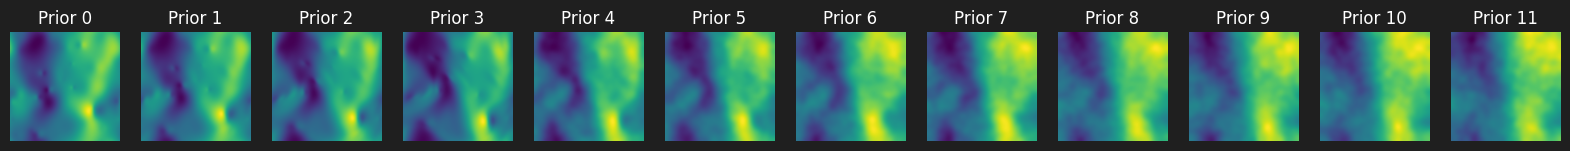

In [101]:
for prior, target in dataloader:
    break
imagescount = 12
print('prior acquired')
fig, ax = plt.subplots(1, imagescount, figsize=(20, 8))
for i in range(imagescount):
    ax[i].imshow(prior[0, i, 0].cpu().numpy(), cmap='viridis')
    ax[i].set_title(f'Prior {i}')
    ax[i].axis('off')

In [104]:
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    From https://github.com/openai/improved-diffusion
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices (float or int)
    :param dim: the embedding dimension
    """
    half = dim // 2
    freqs = torch.exp(-torch.arange(0, half, dtype=torch.float32, device=timesteps.device) * (math.log(max_period) / half))
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = F.pad(embedding, (0, 1))
    return embedding  # shape: [B, dim]

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, time_embed_dim=None, dropprob=0.1):
        super().__init__()
        self.time_embed_dim = time_embed_dim
        self.use_time = time_embed_dim is not None

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='circular'),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='circular'),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

        if self.use_time:
            self.time_mlp = nn.Sequential(
                nn.SiLU(),
                nn.Linear(time_embed_dim, out_channels * 2)  # for scale and shift
            )

    def forward(self, x, t_emb=None):
        out = self.net(x)
        if self.use_time and t_emb is not None:
            gamma, beta = self.time_mlp(t_emb).chunk(2, dim=1)
            gamma = gamma[..., None, None]  # [B, C, 1, 1]
            beta = beta[..., None, None]
            out = out * (1 + gamma) + beta
        return out

class SimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels, base_channels=64, time_embed_dim=128):
        super().__init__()
        in_channels = in_channels + 2  # +2 for (x, y) coordinates

        self.time_embed_dim = time_embed_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # Time-aware convs
        self.before = DoubleConv(in_channels, base_channels, time_embed_dim)
        self.enc1 = DoubleConv(base_channels, base_channels)  # no time here
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(base_channels, base_channels * 2)  # no time here
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base_channels * 2, base_channels * 2, time_embed_dim)

        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels * 2, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(base_channels * 4, base_channels * 2)  # no time here
        #self.dec2 = DoubleConv(base_channels * 2, base_channels * 2)

        self.up1 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(base_channels * 2, base_channels)  # no time here
        #self.dec1 = DoubleConv(base_channels, base_channels)

        self.after = DoubleConv(base_channels, base_channels, time_embed_dim)
        self.out_conv = nn.Conv2d(base_channels, out_channels, kernel_size=1)

    def forward(self, x, t):
        B, T, C, H, W = x.shape
        x = x.view(B, T * C, H, W)
        #print(x.shape)

        # Time embedding
        t_emb = timestep_embedding(t, self.time_embed_dim)  # [B, D]
        t_emb = self.time_mlp(t_emb)  # [B, D]

        # Coordinate grid
        coordsy = torch.linspace(0, 1, steps=H, device=x.device)
        coordsx = torch.linspace(0, 1, steps=W, device=x.device)
        yy, xx = torch.meshgrid(coordsy, coordsx, indexing='ij')
        coord_grid = torch.stack((xx, yy), dim=0).unsqueeze(0).repeat(B, 1, 1, 1)
        x = torch.cat([x, coord_grid], dim=1)

        # UNet forward
        x = self.before(x, t_emb)
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.bottleneck(self.pool2(x2), t_emb)

        x = self.up2(x3)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)

        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x)

        x = self.after(x, t_emb)
        x = self.out_conv(x)
        return x.view(B, -1, 2, H, W)
    
#datashape = 
#in_channels = datashape[1] * datashape[2]  # 2 for (x, y) coordinates
in_channels = 21 * 2 
datashape = (1, 21, 2, 128, 128)  # Example shape: (B, T, C, H, W)
model = SimpleUNet(in_channels=in_channels, out_channels=in_channels, base_channels=128, time_embed_dim=256)
model = model.cuda()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
#x = torch.randn(1, 21, 2, 128, 128).cuda()
#y = model(x, torch.tensor([0.5]).cuda())
xtest = torch.randn(datashape).cuda()
y = model(xtest, torch.tensor([0.5]).cuda())
print(y.shape)


Number of parameters: 5865642
torch.Size([1, 21, 2, 128, 128])


## Training

Epoch 0 Loss: 0.126211, LR: 0.001000


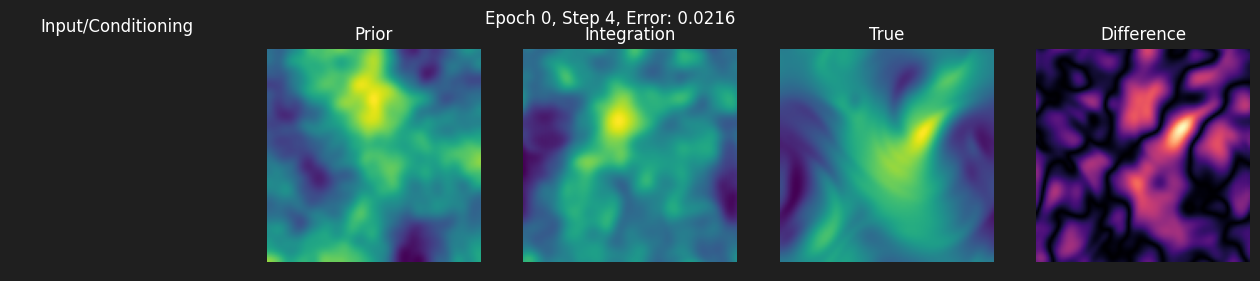

Epoch 1 Loss: 0.074973, LR: 0.001000


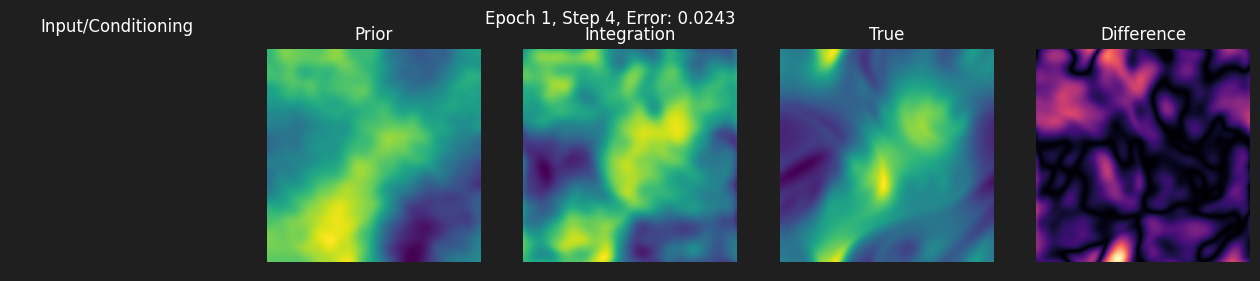

In [ ]:
training_steps = 100#25000
epochs = 200
ratio = 1
eps = 0.001
steps = 40
index_to_plot = -2 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-7
)


def random_fft_perturb(x, perturbation_strength=1.0):
    x_fft = torch.fft.fftshift(torch.fft.fft2(x, dim=(-2, -1)))
    x_fft = x_fft * torch.exp(1j * torch.randn_like(x_fft) * perturbation_strength)
    x_recon = torch.fft.ifft2(torch.fft.ifftshift(x_fft)).real
    return x_recon

def random_fft_init(strength=1.0):
    # make a random gaussian noise in the frequency domain
    noise = torch.randn(21, 2, 128, 128) * strength
    x_recon = random_fft_perturb(noise, perturbation_strength=strength)
    return x_recon.unsqueeze(0).cuda()  # Add batch dimension and move to GPU

def blurred_gaussian_2D(shape):
    B, T, C, H, W = shape
    xnoise = torch.randn(shape)
    kernel_size = 21
    sigma = 4.0
    filter = GaussianBlur(kernel_size=(kernel_size, kernel_size), sigma=sigma)
    xnoise = xnoise.view(1, -1, 128, 128)
    xnoise = filter(xnoise)
    xnoise = xnoise.view(B, T, C, H, W)
    #print(xnoise.shape)
    return xnoise

def blurred_gaussian_4D(shape):
    B, T, C, H, W = shape
    xnoise = np.random.randn(B, T, C, H, W)
    sigma = (0,1.1,0.5,3,3)
    xnoise = gaussian_filter(xnoise, sigma=sigma, mode='wrap', truncate=2.5)
    return torch.tensor(xnoise).float()

def blurred_gaussian_3D(shape):
    B, T, C, H, W = shape
    xnoise = np.random.randn(B, T, C, H, W)
    sigma = (0,1.1,0,3,3)
    xnoise = gaussian_filter(xnoise, sigma=sigma, mode='wrap', truncate=2.5)
    return torch.tensor(xnoise).float()

def gaussian_kernel_3d_torch(kernel_size=7, sigma=1.0, device='cpu'):
    ax = torch.arange(kernel_size, device=device) - kernel_size // 2
    xx, yy, zz = torch.meshgrid(ax, ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2 + zz**2) / (2 * sigma**2))
    kernel = kernel / kernel.sum()
    return kernel

def blurred_gaussian_3D_torch(shape, sigma=1.5, kernel_size=7, device='cuda'):
    B, T, C, H, W = shape
    xnoise = torch.randn(B, C, T, H, W, device=device)

    kernel = gaussian_kernel_3d_torch(kernel_size, sigma, device=device)
    kernel = kernel.view(1, 1, kernel_size, kernel_size, kernel_size)
    kernel = kernel.repeat(C, 1, 1, 1, 1)  # (C, 1, D, H, W)

    pad = kernel_size // 2
    xnoise = F.pad(xnoise, (pad, pad, pad, pad, pad, pad), mode='replicate')
    xblur = F.conv3d(xnoise, kernel, groups=C)

    return xblur

losses = []
torch.cuda.synchronize() ############################################################# JUST FOR CHECKING, REMOVE THIS IN CODE

for epoch in range(epochs):
    epoch_losses = []
    xnoise_time = 0.0
    backprop_time = 0.0
    total_time = 0.0
    log_time = 0.0
    
    model.train()
    for j in range(training_steps):
        for prior, target in dataloader:
            prior, target = prior.cuda(), target.cuda()
        
            #t2 = time.time()
            optimizer.zero_grad()
            #t0 = time.time()
            
            #xnoise = torch.randn_like(y, device=y.device)
            #xnoise = random_fft_perturb(x, perturbation_strength=ratio)
            #xnoise = blurred_gaussian_3D(y.shape).cuda()  # Use blurred noise
            #torch.cuda.synchronize()
            #xnoise_time += (time.time() - t0)
            #t1 = time.time()
            
            tf = torch.rand(target.shape[0], device=target.device) #* (1 - eps) + eps
            t_expand = tf.view(-1, 1, 1, 1, 1).repeat(
                        1, target.shape[1], target.shape[2], target.shape[3], target.shape[4]
                    )
            xt = t_expand * target.clone() + (1 - t_expand) * prior.clone()
            target_vector = target.clone() - prior.clone()
            #print(xt.shape)
            pred = model(xt, tf)
            loss = ((pred - target_vector)**2).mean()
            loss.backward()
            optimizer.step()
            #torch.cuda.synchronize()
            #backprop_time += (time.time() - t1)
            #t3 = time.time()
            #loss_value = loss.item()
            losses.append(loss.item())
            #torch.cuda.synchronize()
            #log_time += (time.time() - t3)
            epoch_losses.append(loss.item())
            #torch.cuda.synchronize()
            #total_time += (time.time() - t2)
        if j % 10 == 0:
            print(f"Step {j} | Loss: {loss.item():.6f} ", end='\r')
    print(" ", end='\r')
    print(f"Epoch {epoch} Loss: {np.mean(epoch_losses):.6f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
            
    model.eval()
    with torch.no_grad():
        for prior, target in dataloader:
            prior, target = prior.cuda(), target.cuda()
            #xnoise = torch.randn_like(y, device=y.device)
            #xnoise = random_fft_perturb(x, perturbation_strength=ratio)
            #xnoise = blurred_gaussian_3D(y.shape).cuda()  # Use blurred noise
            #t2 = time.time()
            xt = prior.clone()  
            for tf in torch.linspace(0, 1 - 1/steps, steps):
                pred = model(xt, tf.expand(xt.size(0)).cuda())  # Predict the next step
                xt = xt.clone() + (1 / steps) * pred
            #integration_time = time.time() - t2
            #x = x.detach().cpu().numpy()
            xt = xt.detach().cpu().numpy()
            prior = prior.detach().cpu().numpy()

            target = target.detach().cpu().numpy()
            
            fig, ax = plt.subplots(1, 5, figsize=(16, 3))
            for i in range(5):
                ax[i].axis('off')
            #ax[0].imshow(x[0, index_to_plot, 0])
            ax[1].imshow(prior[0, index_to_plot, 0])
            ax[2].imshow(xt[0, index_to_plot, 0])
            ax[3].imshow(target[0, index_to_plot, 0])
            ax[4].imshow(np.abs(target[0, index_to_plot, 0] - xt[0, index_to_plot, 0]), cmap='magma')

            ax[0].set_title('Input/Conditioning')
            ax[1].set_title('Prior')
            ax[2].set_title('Integration')
            ax[3].set_title('True')
            ax[4].set_title('Difference')
            plt.suptitle(f'Epoch {epoch}, Step {i}, Error: {np.mean(np.abs(target[0, 0, 0] - xt[0, 0, 0])):.4f}')# | Integration Time: {integration_time:.2f}s')
            #plt.tight_layout()
            plt.show()
    scheduler.step(np.mean(epoch_losses))

In [ ]:
filter = GaussianBlur(kernel_size=(5, 5), sigma=1.0)
x = torch.randn(1, 2, 2, 128, 128)
# fuse the first two dimensions
x = x.view(1, 2 * 2, 128, 128)
x_blurred = filter(x)

print(x_blurred.shape)

torch.Size([1, 4, 128, 128])


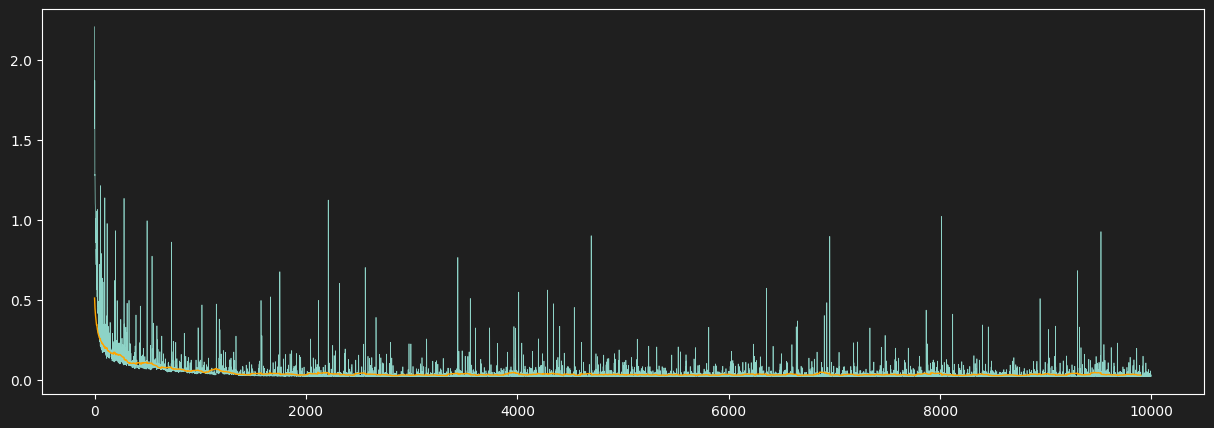

In [27]:
# plot losses
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(losses, linewidth=0.5)
# plot average filter
# plot average filter of the losses without pandas
ax.plot([sum(losses[i:i+100])/100 for i in range(len(losses)-100)], linewidth=1, color='orange')
#ax.set_ylim(0, 4)


In [60]:
# lower learning rate manually
#optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 10000
for y in dataloader:
    print(y.mean(), y.std())

tensor(-6.9849e-09) tensor(1.)


## Inference

In [34]:
model.eval()
shape = torch.Size([64, 2, 2, 128, 128])
steps = 40
'''
for x, y in dataloader:
    x, y = x.cuda(), y.cuda()
    print(x.std(), x.mean())
    xnoise = random_fft_perturb(x, perturbation_strength=ratio)
    print(xnoise.std(), xnoise.mean())
    break  

xt = xnoise.clone()
'''
with torch.no_grad():
    for y in dataloader:
        y = y.cuda()
        print(y.std(), y.mean())
        xnoise = torch.randn_like(y, device=y.device)
        #xnoise = random_fft_perturb(y, perturbation_strength=ratio)
        #xnoise = random.uniform(-1, 1) * torch.ones_like(y, device=y.device)
        #xnoise = random.normalvariate(0, 1) * torch.ones_like(y, device=y.device)  # Initial noise
        #xnoise = torch.zeros_like(y, device=y.device)  #torch.randn_like(y, device=y.device) * ratio
        print(xnoise.std(), xnoise.mean())
    print("Integrating...")
    xt = xnoise.clone()  # Start from noise
    for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
        pred = model(xt, t.expand(xt.size(0)).cuda())  # Predict the next step
        xt = xt + (1 / steps) * pred
        print(f"Sampling step {i}/{steps} done", end='\r')

print("Done Sampling")

tensor(1., device='cuda:0') tensor(0., device='cuda:0')
tensor(1.0010, device='cuda:0') tensor(-0.0038, device='cuda:0')
Integrating...
Done Sampling 40/40 done


In [35]:
print(xt.shape)
xt = xt.detach().cpu().numpy()
xnoise = xnoise.detach().cpu().numpy()
#x = x.cpu().numpy()
y = y.detach().cpu().numpy()

torch.Size([1, 1, 2, 128, 128])


Input Noise mean and std -0.0038118744 1.0009604


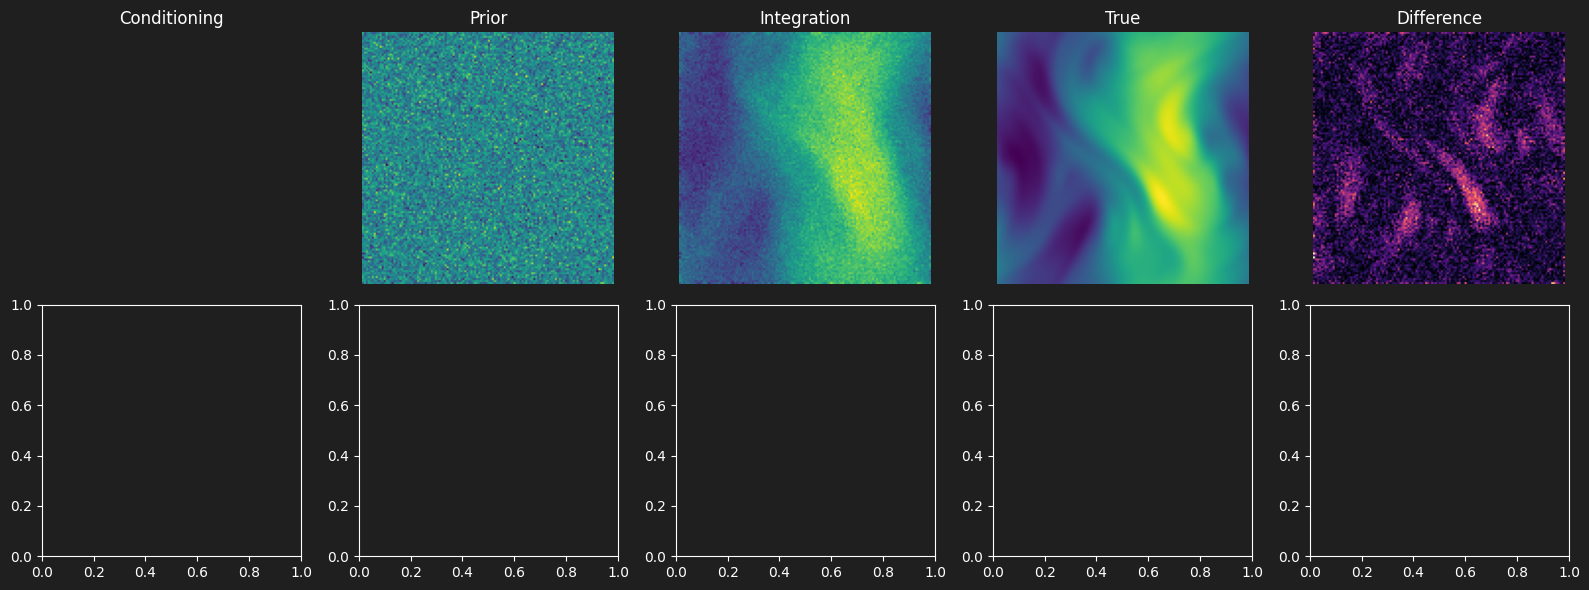

In [36]:
items = 2
fig, ax = plt.subplots(items, 5, figsize=(16, 3 * items))
for i in range(items):
    # turn axis off
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 3].axis('off')
    ax[i, 4].axis('off')
    ax[i, 1].imshow(xnoise[0, i, 0])
    ax[i, 2].imshow(xt[0, i, 0])
    ax[i, 3].imshow(y[0, i, 0])
    ax[i, 4].imshow(np.abs(y[0, i, 0] - xt[0, i, 0]), cmap='magma')
    break
ax[0, 0].set_title('Conditioning')
ax[0, 1].set_title('Prior')
ax[0, 2].set_title('Integration')
ax[0, 3].set_title('True')
ax[0, 4].set_title('Difference')
print('Input Noise mean and std', xnoise.mean(), xnoise.std())
plt.tight_layout()

In [355]:
model

SimpleUNet(
  (enc1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(45, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (4): BatchNorm2

In [ ]:
model.eval().requires_grad_(False)
shape = torch.Size([64, 2, 2, 128, 128])
for x, y in dataloader:
    x, y = x.cuda(), y.cuda()
    print(x.std(), x.mean())
    # take first element of batch
    x = x[0].repeat(8, 1, 1, 1, 1)
    y = y[0].repeat(8, 1, 1, 1, 1)
    xnoise = random_fft_perturb(x, perturbation_strength=ratio)
    break
steps = 100
xt = xnoise.clone()

print("Integrating...")
for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
    pred = model(xt, t.expand(xt.size(0)).cuda())  
    xt = xt + (1 / steps) * pred
    print(f"Sampling step {i}/{steps} done", end='\r')
model.train().requires_grad_(True)

xt = xt.cpu().numpy()
xnoise = xnoise.cpu().numpy()
x = x.cpu().numpy()
y = y.cpu().numpy()

fig, ax = plt.subplots(4, 5, figsize=(16, 18))
for i in range(4):
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 3].axis('off')
    ax[i, 4].axis('off')
    ax[i, 0].imshow(x[i, 0, 0])
    ax[i, 1].imshow(xnoise[i, 0, 0])
    ax[i, 2].imshow(xt[i, 0, 0])
    ax[i, 3].imshow(y[i, 0, 0])
    ax[i, 4].imshow(np.abs(y[i, 0, 0] - xt[i, 0, 0]), cmap='magma')
ax[0, 0].set_title('Input')
ax[0, 1].set_title('Input Noise')
ax[0, 2].set_title('Flowmatched Output')
ax[0, 3].set_title('Target')
ax[0, 4].set_title('Difference')

plt.tight_layout()

ValueError: not enough values to unpack (expected 2, got 1)

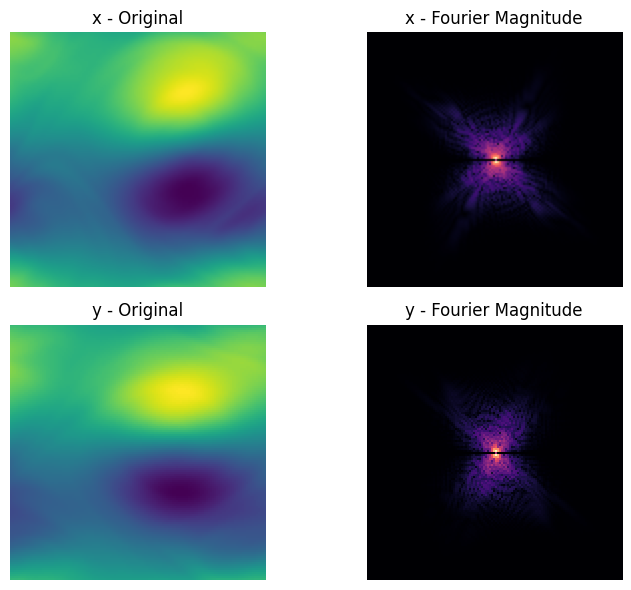

In [23]:
import torch.fft

for i, (x, y) in enumerate(dataloader):
    x, y = x.cuda(), y.cuda()

    # Example: visualize first sample in batch
    x_sample = x[0].detach().cpu()  # shape [2, 2, 128, 128]
    y_sample = y[0].detach().cpu()

    # Select one channel to visualize (e.g., channel 0, component 0)
    x_vis = x_sample[0, 0]  # shape [128, 128]
    y_vis = y_sample[0, 0]

    # Compute 2D Fourier transforms and take magnitude
    x_fft = torch.fft.fftshift(torch.fft.fft2(x_vis))
    y_fft = torch.fft.fftshift(torch.fft.fft2(y_vis))
    x_fft_mag = x_fft.abs().log1p()
    y_fft_mag = y_fft.abs().log1p()

    # Plot
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))

    axs[0, 0].imshow(x_vis, cmap='viridis')
    axs[0, 0].set_title('x - Original')
    axs[0, 1].imshow(x_fft_mag, cmap='magma')
    axs[0, 1].set_title('x - Fourier Magnitude')

    axs[1, 0].imshow(y_vis, cmap='viridis')
    axs[1, 0].set_title('y - Original')
    axs[1, 1].imshow(y_fft_mag, cmap='magma')
    axs[1, 1].set_title('y - Fourier Magnitude')

    for ax in axs.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    break  # remove this if you want to see more batches

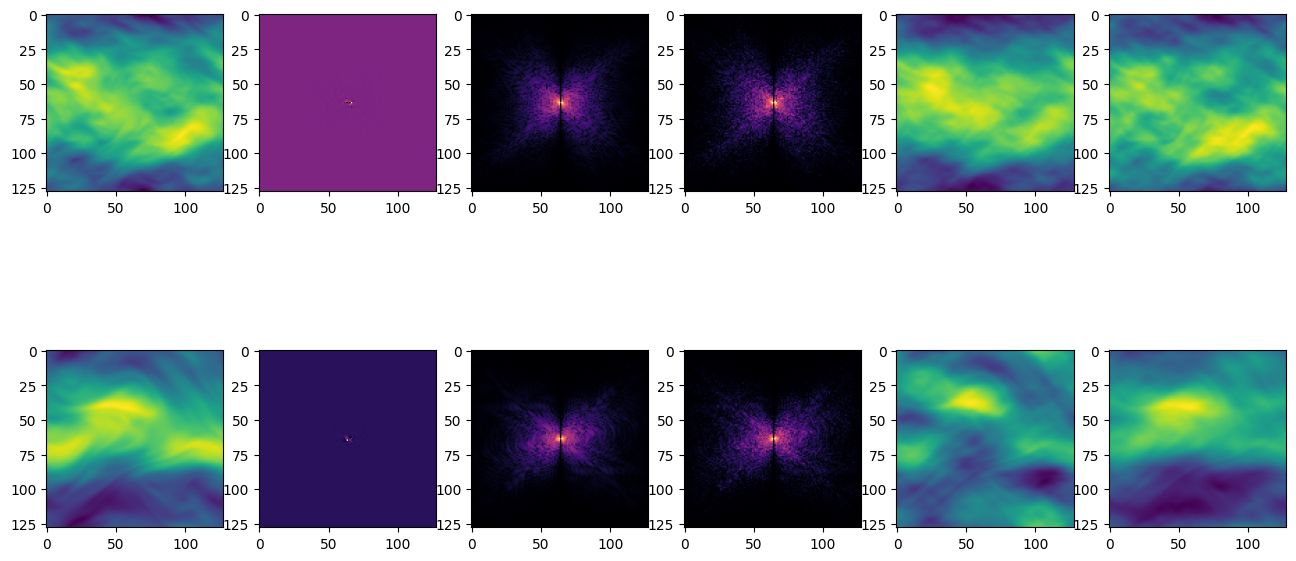

In [179]:
for i, (x, y) in enumerate(dataloader):
    x, y = x.cuda(), y.cuda()
    # fourier space
    break

x_fft = torch.fft.fftshift(torch.fft.fft2(x, dim=(-2, -1)))
y_fft = torch.fft.fftshift(torch.fft.fft2(y, dim=(-2, -1)))

x_fft_mag = x_fft.abs().log1p()
y_fft_mag = y_fft.abs().log1p()
x_fft_phase = torch.angle(x_fft)
y_fft_phase = torch.angle(y_fft)

# perturb?\
perturbation_strength = 0.8
x_fft = x_fft * torch.exp(1j * torch.randn_like(x_fft) * perturbation_strength)
y_fft = y_fft * torch.exp(1j * torch.randn_like(y_fft) * perturbation_strength)
x_fft_mag2 = x_fft.abs().log1p()
y_fft_mag2 = y_fft.abs().log1p()

x_recon = torch.fft.ifft2(torch.fft.ifftshift(x_fft)).real
y_recon = torch.fft.ifft2(torch.fft.ifftshift(y_fft)).real

def random_fft_perturb(x, perturbation_strength=0.4):
    x_fft = torch.fft.fftshift(torch.fft.fft2(x, dim=(-2, -1)))
    x_fft = x_fft * torch.exp(1j * torch.randn_like(x_fft) * perturbation_strength)
    x_recon = torch.fft.ifft2(torch.fft.ifftshift(x_fft)).real
    return x_recon

x_recon2 = random_fft_perturb(x, perturbation_strength=perturbation_strength)
y_recon2 = random_fft_perturb(y, perturbation_strength=perturbation_strength)

fig, axs = plt.subplots(2, 6, figsize=(16, 8))
axs[0, 0].imshow(x[0, 0, 0].cpu(), cmap='viridis')
axs[0, 1].imshow(x_fft[0, 0, 0].real.cpu(), cmap='magma')
axs[0, 2].imshow(x_fft_mag[0, 0, 0].cpu(), cmap='magma')
axs[0, 3].imshow(x_fft_mag2[0, 0, 0].cpu(), cmap='magma')
axs[0, 4].imshow(x_recon[0, 0, 0].cpu(), cmap='viridis')
axs[0, 5].imshow(x_recon2[0, 0, 0].cpu(), cmap='viridis')

axs[1, 0].imshow(y[0, 0, 0].cpu(), cmap='viridis')
axs[1, 1].imshow(y_fft[0, 0, 0].real.cpu(), cmap='magma')
axs[1, 2].imshow(y_fft_mag[0, 0, 0].cpu(), cmap='magma')
axs[1, 3].imshow(y_fft_mag2[0, 0, 0].cpu(), cmap='magma')
axs[1, 4].imshow(y_recon[0, 0, 0].cpu(), cmap='viridis')
axs[1, 5].imshow(y_recon2[0, 0, 0].cpu(), cmap='viridis')
plt.show()

In [174]:

def random_fft_perturb(x, perturbation_strength=0.4):
    x_fft = torch.fft.fftshift(torch.fft.fft2(x, dim=(-2, -1)))
    x_fft = x_fft * torch.exp(1j * torch.randn_like(x_fft) * perturbation_strength)
    x_recon = torch.fft.ifft2(torch.fft.ifftshift(x_fft)).real
    return x_recon


In [ ]:
shifts = [
        (0, 1),    # right
        (0, -1),   # left
        (1, 0),    # down
        (-1, 0),   # up
        (1, 1),    # down-right
        (-1, -1),  # up-left
        (-1, 1),   # up-right
        (1, -1),   # down-left
        (0, 0)     # no shift
    ]
def random_roll_tensor(tensor, how_many=1):
    for _ in range(how_many):
        dy, dx = shifts[torch.randint(len(shifts), (1,)).item()]
        tensor = torch.roll(tensor, shifts=(dy, dx), dims=(-2, -1))
    return tensor
